# 电影推荐实验

本实验用协同过滤技术分析用户对电影的评分数据，并基于这个数据建立一个推荐系统，根据用户输入的一部感兴趣的电影，为其推荐其他可能感题目的电影。此案实验中，我们使用的数据集是MovieLens数据集中的ml-100k————用户对电影的评分数据，包含用户数据、评分数据、电影数据。
本文件主要是复现华为推荐系统实验部分，基于物品的协同过滤算法。

1.导入数据集ml-100k
2.将导入数据做一定程度的预处理，以满足构建模型的要求
3.创建用户-电影评分矩阵
4.创建电影的相似矩阵
5.根据电影的相似矩阵，推荐电影
6.保存结果

### 导入基本工具库
执行下面方框中的这段代码，可以导入本次实验中使用的Python开发基本工具库。

    numpy                数据分处理工具
    pandas               文件读取和数据处理工具
    scipy                一个科学计算库
    cosine、correlation  两种距离计算方法
    matplotlib           一个2D绘图法

In [244]:
# import same usefull libraries
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

### 导入并展示样本数据
使用pandas库导入用户的个人信息

用户数据的字段描述如下：
* user_id：用户ID
* age：用户年龄
* sex：性别
* occupation：职业
* zip_code：邮编

评分数据的字段描述如下：
* user_id：用户ID
* movide_id：电影ID
* rating：评分
* unix_tiemstamp：评分时间

电影数据的字段描述如下：
* user_id：用户ID
* movie_title：电影名
* release_date：上映日期
* IMDb_URL：IMDb链接

In [245]:
# 用户信息
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./ml-100k/u.user', sep='|', names=users_cols, parse_dates=True)
# Ratings
rating_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('./ml-100k/u.data', sep='\t', names=rating_cols)
# Movies
movie_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('./ml-100k/u.item', sep='|', names=movie_cols, usecols=range(5), encoding='latin-1')

In [246]:
#用户信息
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


使用pandas库导入用户的评分信息

In [247]:
#评分信息
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [248]:
#电影信息
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


### 数据合并

把电影数据表、评论数据表、用户信息数据表进行合并，最后得到一张数据信息总表

In [249]:
# Merging movie data with their ratings
movie_ratings = pd.merge(movies, ratings)
# merging movie_ratings data with the User's dataframe
df = pd.merge(movie_ratings, users)

查看数据信息总表

In [250]:
df.head()

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,287,5,875334088,21,M,salesman,31211
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,148,4,877019411,33,M,engineer,97006
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,280,4,891700426,30,F,librarian,22903
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,66,3,883601324,23,M,student,80521


打印数据总表的大小，可以看到这是一个 10000x12的矩阵， 其中10000代表有10000条评论，12代表每条评论有12项属性，包括电影ID，电影信息，用户ID，评分，用户信息等

In [251]:
df.shape

(100000, 12)

### 数据清洗

去除一些无效或不需要的信息，比如video_release_date、imdb_url、unix_timestamp

In [252]:
# pre-processing
# dropping colums that aren't needed
df.drop(df.columns[[3, 4, 7]], axis=1, inplace=True)
ratings.drop("unix_timestamp", inplace=True, axis=1)
movies.drop(movies.columns[[3, 4]], inplace=True, axis=1)

查看新的数据信息总表

In [253]:
df.head()

,movie_id,title,release_date,user_id,rating,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,308,4,60,M,retired,95076
1,1,Toy Story (1995),01-Jan-1995,287,5,21,M,salesman,31211
2,1,Toy Story (1995),01-Jan-1995,148,4,33,M,engineer,97006
3,1,Toy Story (1995),01-Jan-1995,280,4,30,F,librarian,22903
4,1,Toy Story (1995),01-Jan-1995,66,3,23,M,student,80521


### 创建用户-电影评分矩阵

根据评分数据表(ratings),创建用户-电影评分矩阵 

In [254]:
# Pivot Table(This creates a matrix of users and movie_ratings)
ratings_matrix = ratings.pivot_table(index=['movie_id'], columns=['user_id'], values='rating').reset_index(drop=True)
ratings_matrix.fillna(0, inplace=True)
cmu = ratings_matrix

查看用户-电影评分矩阵，其中每一行代表每部电影来自所有用户的评分；每一列代表每个用户对所有电影的评分。

In [255]:
cmu.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
0,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
1,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


打印数据总表的大小，可以看到这是一个 1682x943的矩阵， 其中1682代表有1682部电影，943代表有943个用户

### 创建电影的相似矩阵

根据943位用户对每部电影的评分，创建1682部电影的相似矩阵，矩阵大小为1682x1682的形状。

In [272]:
# Cosine Similarity(Creates a cosine matrix of similaraties ..... which is the pairwise distances
# between two items )

movie_similarity = 1 - pairwise_distances(ratings_matrix.values, metric="cosine")
np.fill_diagonal(movie_similarity, 0)
ratings_matrix = pd.DataFrame(movie_similarity)

查看电影相似矩阵，以第三行，第二列为例，数值为0.273069，这个值代表第二部电影与第三部电影的相似度

In [273]:
ratings_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,0.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,...,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
1,0.402382,0.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
2,0.330245,0.273069,0.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,...,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
3,0.454938,0.502571,0.324866,0.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,...,0.000000,0.0,0.094022,0.094022,0.037609,0.0,0.0,0.0,0.056413,0.075218
4,0.286714,0.318836,0.212957,0.334239,0.000000,0.037299,0.334769,0.259161,0.272448,0.055453,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094211


### ItemCF，推荐电影

当用户查看了 Copycat (1995)，那么根据电影的相似矩阵，推荐与 Copycat (1995) 近似分数比较高的电影。

具体如下：

根据电影名 Copycat (1995)， 查询电影信息表 (movies)中的index序号

In [274]:
# user_inp=input('Enter the reference movie title based on which recommendations are to be made: ')
user_inp = "Copycat (1995)"
inp = movies[movies['title'] == user_inp].index.tolist()
inp = inp[0]

根据电影index序号，去查电影的相似矩阵，得到1682部电影的相似值，并打印表格中的5部电影的相似值

In [275]:
movies['similarity'] = ratings_matrix.iloc[inp]
movies.columns = ['movie_id', 'title', 'release_date', 'similarity']
movies.head(5)

,movie_id,title,release_date,similarity
0,1,Toy Story (1995),01-Jan-1995,0.286714
1,2,GoldenEye (1995),01-Jan-1995,0.318836
2,3,Four Rooms (1995),01-Jan-1995,0.212957
3,4,Get Shorty (1995),01-Jan-1995,0.334239
4,5,Copycat (1995),01-Jan-1995,0.000000


把相似值进行排序，并打印最相似的10部电影，并将推荐的电影信息写入到文本文件中。会打印成功保存的信息。

In [276]:
recommended_movies = movies.sort_values(["similarity"], ascending=False)[1:11]

# 输出结果,并保存至本地文件
print("根据您选择的电影 " + user_inp + " 推荐的电影:")
with open("recommended_movies.txt", "w", encoding='utf-8') as file:
    for index, (i, row) in enumerate(recommended_movies.iterrows(), 1):
        movie_info = f"NO.{index}  电影：{row['title']} - 相似度值: {row['similarity']:.2f}"
        print(movie_info)
        file.write(movie_info + "\n")
print("结果保存至 recommended_movies.txt 文件中。")

根据您选择的电影 Copycat (1995) 推荐的电影:
NO.1  电影：Nightmare on Elm Street, A (1984) - 相似度值: 0.47
NO.2  电影：Outbreak (1995) - 相似度值: 0.47
NO.3  电影：Jaws (1975) - 相似度值: 0.45
NO.4  电影：Natural Born Killers (1994) - 相似度值: 0.45
NO.5  电影：Silence of the Lambs, The (1991) - 相似度值: 0.44
NO.6  电影：Candyman (1992) - 相似度值: 0.44
NO.7  电影：Shining, The (1980) - 相似度值: 0.43
NO.8  电影：Alien 3 (1992) - 相似度值: 0.43
NO.9  电影：Interview with the Vampire (1994) - 相似度值: 0.42
NO.10  电影：Basic Instinct (1992) - 相似度值: 0.42
结果保存至 recommended_movies.txt 文件中。


电影推荐可视化，评分前10的电影放入折线图中。

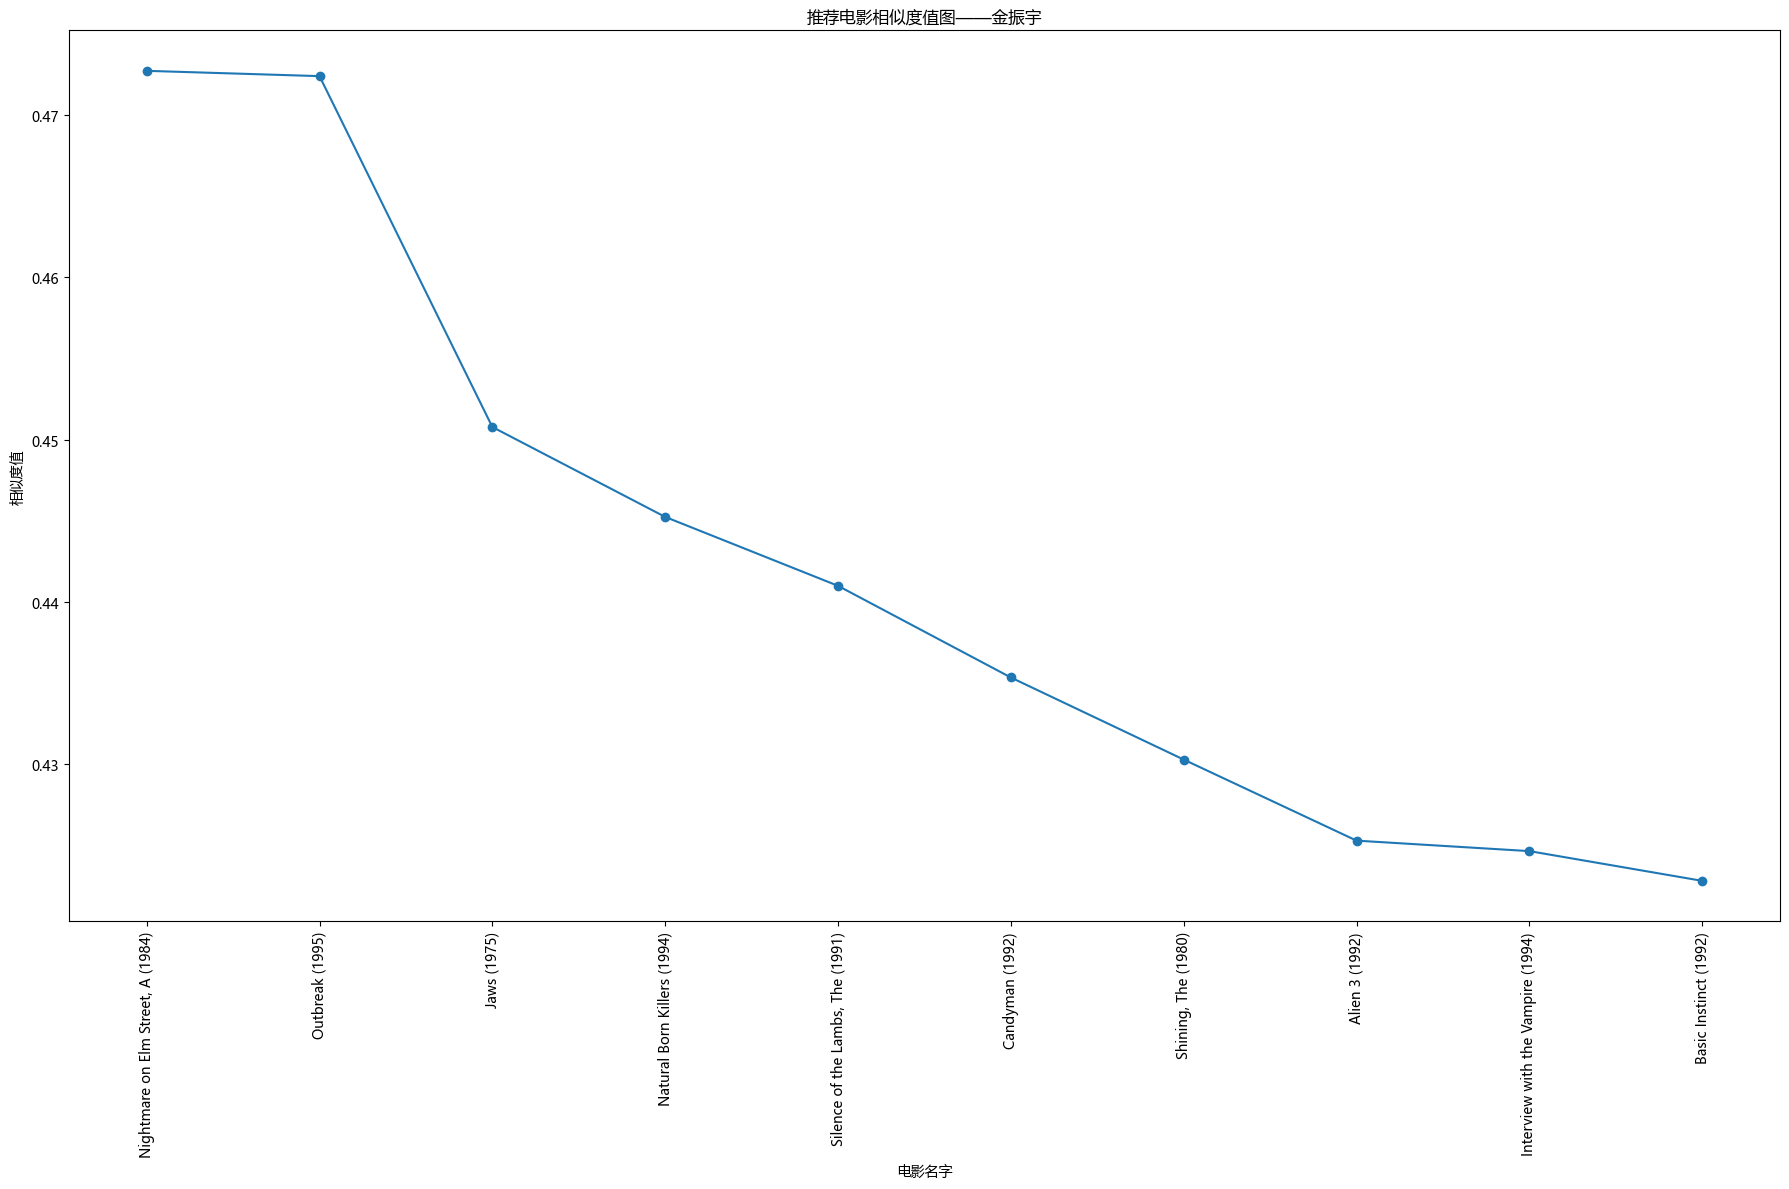

In [277]:
recommended_movies = movies.sort_values(["similarity"], ascending=False)[1:11]

# 设置matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 获取电影名字和相似度值
movie_titles = recommended_movies['title'].tolist()
similarities = recommended_movies['similarity'].tolist()

# 创建折线图
plt.figure(figsize=(18,12))
plt.plot(movie_titles, similarities, marker='o')

# 添加标题和标签
plt.title('推荐电影相似度值图——金振宇')
plt.xlabel('电影名字')
plt.ylabel('相似度值')
plt.xticks(rotation=90)  # 电影名字标签旋转90度，以便清晰显示

# 显示图表
plt.tight_layout()  # 调整布局以适应标签
plt.show
plt.savefig('./1.jpg')